In [1]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM
from torch.nn.functional import log_softmax
import torch
import numpy as np
import json
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from matplotlib import pyplot as plt

/Users/aron/codebase/uniwork/cicl/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AutoModelForCausalLM.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
bos = tokenizer.bos_token_id
eos = tokenizer.eos_token_id

In [3]:
def encode(string):
    ids, words_ids, sentence_ids = [], [], []
    sentences = sent_tokenize(string, language='english')
    token_idx = 0
    for sent_id, sentence in enumerate(sentences):
        tokens = sentence.split(" ")
        for token in tokens:
            token_ids = tokenizer.encode(token, add_special_tokens=False)
            ids.extend(token_ids)
            words_ids.extend([token_idx] * len(token_ids))
            sentence_ids.extend([sent_id] * len(token_ids))
            token_idx += 1
    return ids, words_ids, sentence_ids

encode("Hello world! This is a test.")
            

([15496, 6894, 0, 1212, 271, 64, 9288, 13],
 [0, 1, 1, 2, 3, 4, 5, 5],
 [0, 0, 0, 1, 1, 1, 1, 1])

In [4]:
taskC_train = []
with open ("data/subtaskC_train.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line:
            parsed = json.loads(line)
            taskC_train.append((parsed["text"], parsed["label"], parsed["id"]))

In [5]:
def perplexity(logits, labels):
    sm = log_softmax(logits, dim=-1)
    probs = []
    for i in range(labels.shape[1] - 1):
        next_idx = labels[0, i + 1].item()
        scores = sm[0, i, :]
        prob_next_idx = scores[next_idx].item()
        probs.append(prob_next_idx)

    probs = np.array(probs)
    probs = np.sum(probs)
    l = labels.shape[1] - 1
    ppl = - (1 / l) * np.sum(probs)
    return np.exp(ppl)

In [6]:
def ppl_sequential(string):
    result = []
    window_size = 1020
    slide_amount = 256
    
    all_ids, all_words, _ = encode(string)
    
    window_start = 0
    done = False
    while not done:
        window_end = window_start + window_size
        pos = 0 if window_start == 0 else window_end - slide_amount
        ids = all_ids[window_start:window_end]
        words = all_words[window_start:window_end]
        
        __ids = torch.tensor([bos] + ids + [eos]).unsqueeze(0)
        __out = model(__ids)
        __words = [0] + [r+1 for r in words] + [len(words) + 1]
        
        for i, word_id in enumerate(__words[pos:]):
            i = i + pos
            word_id = __words[i]
            if i == 0:
                # ignore BOS
                continue
            elif i == len(__words) - 1 or __words[i+1] != word_id:
                logits = __out.logits[:, :i+1, :]
                input_tensor = __ids[:, :i+1]
                ppl = perplexity(logits, input_tensor)
                result.append(ppl)
        
        if window_start + window_size >= len(all_ids):
            # in this order because one pass should be done
            # even if over
            done = True
        window_start += slide_amount
    
    # remove EOS
    result.pop(-1)
    return result

   

In [7]:
def ppl_sentences(string):
    result = []
    all_ids, all_words, all_sents = encode(string)
    for i, sent_id in enumerate(all_sents):
        if i == len(all_sents) - 1 or all_sents[i+1] != sent_id:
            sent_start = all_sents.index(sent_id)
            input_ids = [bos] + all_ids[sent_start:i+1] + [eos]
            input_tensor = torch.tensor(input_ids).unsqueeze(0)
            out = model(input_tensor)
            ppl = perplexity(out.logits, input_tensor)
            word_count = len(set(all_words[sent_start:i+1]))
            result.extend([ppl] * word_count)
    return result
            

In [27]:
def ppl_sent_words(string):
    result = []
    all_ids, all_words, all_sents = encode(string)
    for i, sent_id in enumerate(all_sents):
        if i == len(all_sents) - 1 or all_sents[i+1] != sent_id:
            sent_start = all_sents.index(sent_id)
            input_ids = [bos] + all_ids[sent_start:i+1] + [eos]
            input_tensor = torch.tensor(input_ids).unsqueeze(0)
            out = model(input_tensor)
            for word_i, word_id in enumerate(all_words[sent_start:i+1]):
                abs_index = word_i + sent_start
                if word_i == 0:
                    continues
                elif abs_index == i or all_words[abs_index+1] != word_id:
                    logits = out.logits[:, :word_i+1, :]
                    input_tensor = input_tensor[:, :word_i+1]
                    ppl = perplexity(logits, input_tensor)
                    result.append(ppl)
    return result

In [9]:
def rolling_avg(arr, window_size=10):
    if window_size == 0:
        return arr
    r = []
    i = 0
    while i < len(arr):
        mid = window_size // 2
        start = max(i - mid, 0)
        end = min(i + mid, len(arr) + 1)
        current = sum(arr[start:end]) / (end - start)
        r.append(current)
        i += 1
    return r  

def rolling_variance(arr, window_size=10):
    r = []
    i = 0
    while i < len(arr):
        mid = window_size // 2
        start = max(i - mid, 0)
        end = min(i + mid, len(arr) + 1)
        current = np.var(arr[start:end])
        r.append(current)
        i += 1
    return r

def flatten_outliers(arr, maximum=5000):
    return [i if i <= maximum else maximum for i in arr]
    

674 649


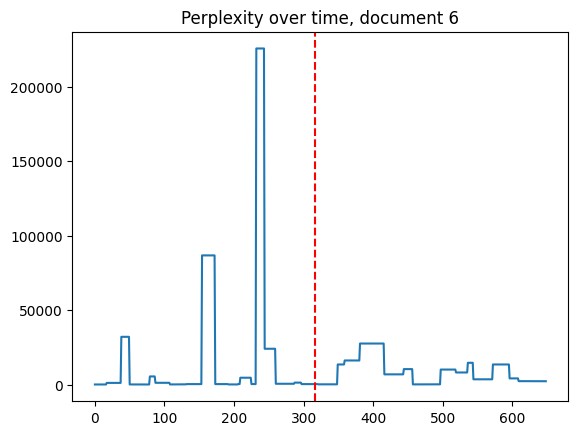

In [36]:
idx = 6
_, words, _ = encode(taskC_train[idx][0])
# ppl_global = ppl_sequential(taskC_train[idx][0])
# ppl_sents = ppl_sentences(taskC_train[idx][0])
ppl_local = ppl_sent_words(taskC_train[idx][0])
print((len(set(words))), len(ppl_local))
# print(len(set(words)), len(ppl_global), len(ppl_sents), len(ppl_local))
# ppl_sents = flatten_outliers(ppl_sents, maximum=2000)

# ppl_global = ppl_sequential(taskC_train[idx][0])
label = taskC_train[idx][1]

plt.plot(ppl_local)
# plt.plot(ppl_global)
plt.axvline(label, color="red", linestyle="--")
plt.title(f"Perplexity over time, document {idx}")
plt.show()